In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [4]:
np.random.seed(42)
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

In [5]:
skin_df=pd.read_csv("HAM10000_metadata.csv")
SIZE=32

In [6]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [7]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [8]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

<Figure size 1500x1000 with 0 Axes>

In [9]:
ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

In [10]:
ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex')

Text(0.5, 1.0, 'Sex')

Text(0.5, 1.0, 'Localization')

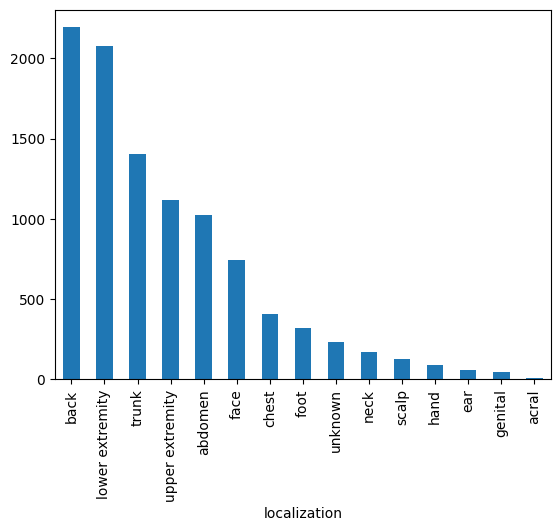

In [11]:
ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

C:\Users\HP\AppData\Local\Temp\ipykernel_26820\3829969692.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


Text(0.5, 1.0, 'Age')

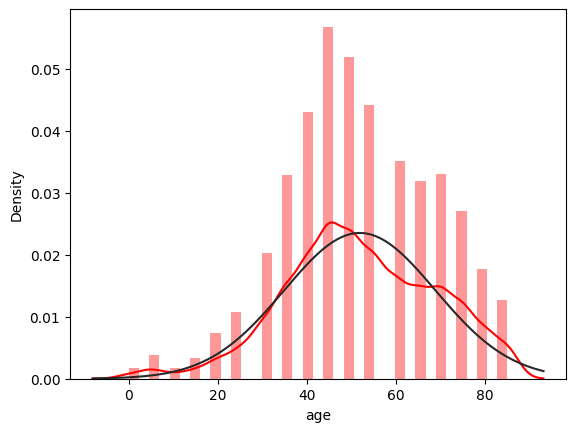

In [12]:
ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

In [13]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [14]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [15]:
#Balancing data
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [16]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [17]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [18]:
#reading images from dataset
print(skin_df_balanced['label'].value_counts())


label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [19]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('data/', '*', '*.jpg'))}

In [20]:
#Defining the path and adding as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [21]:
#Using the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [22]:
n_samples = 5

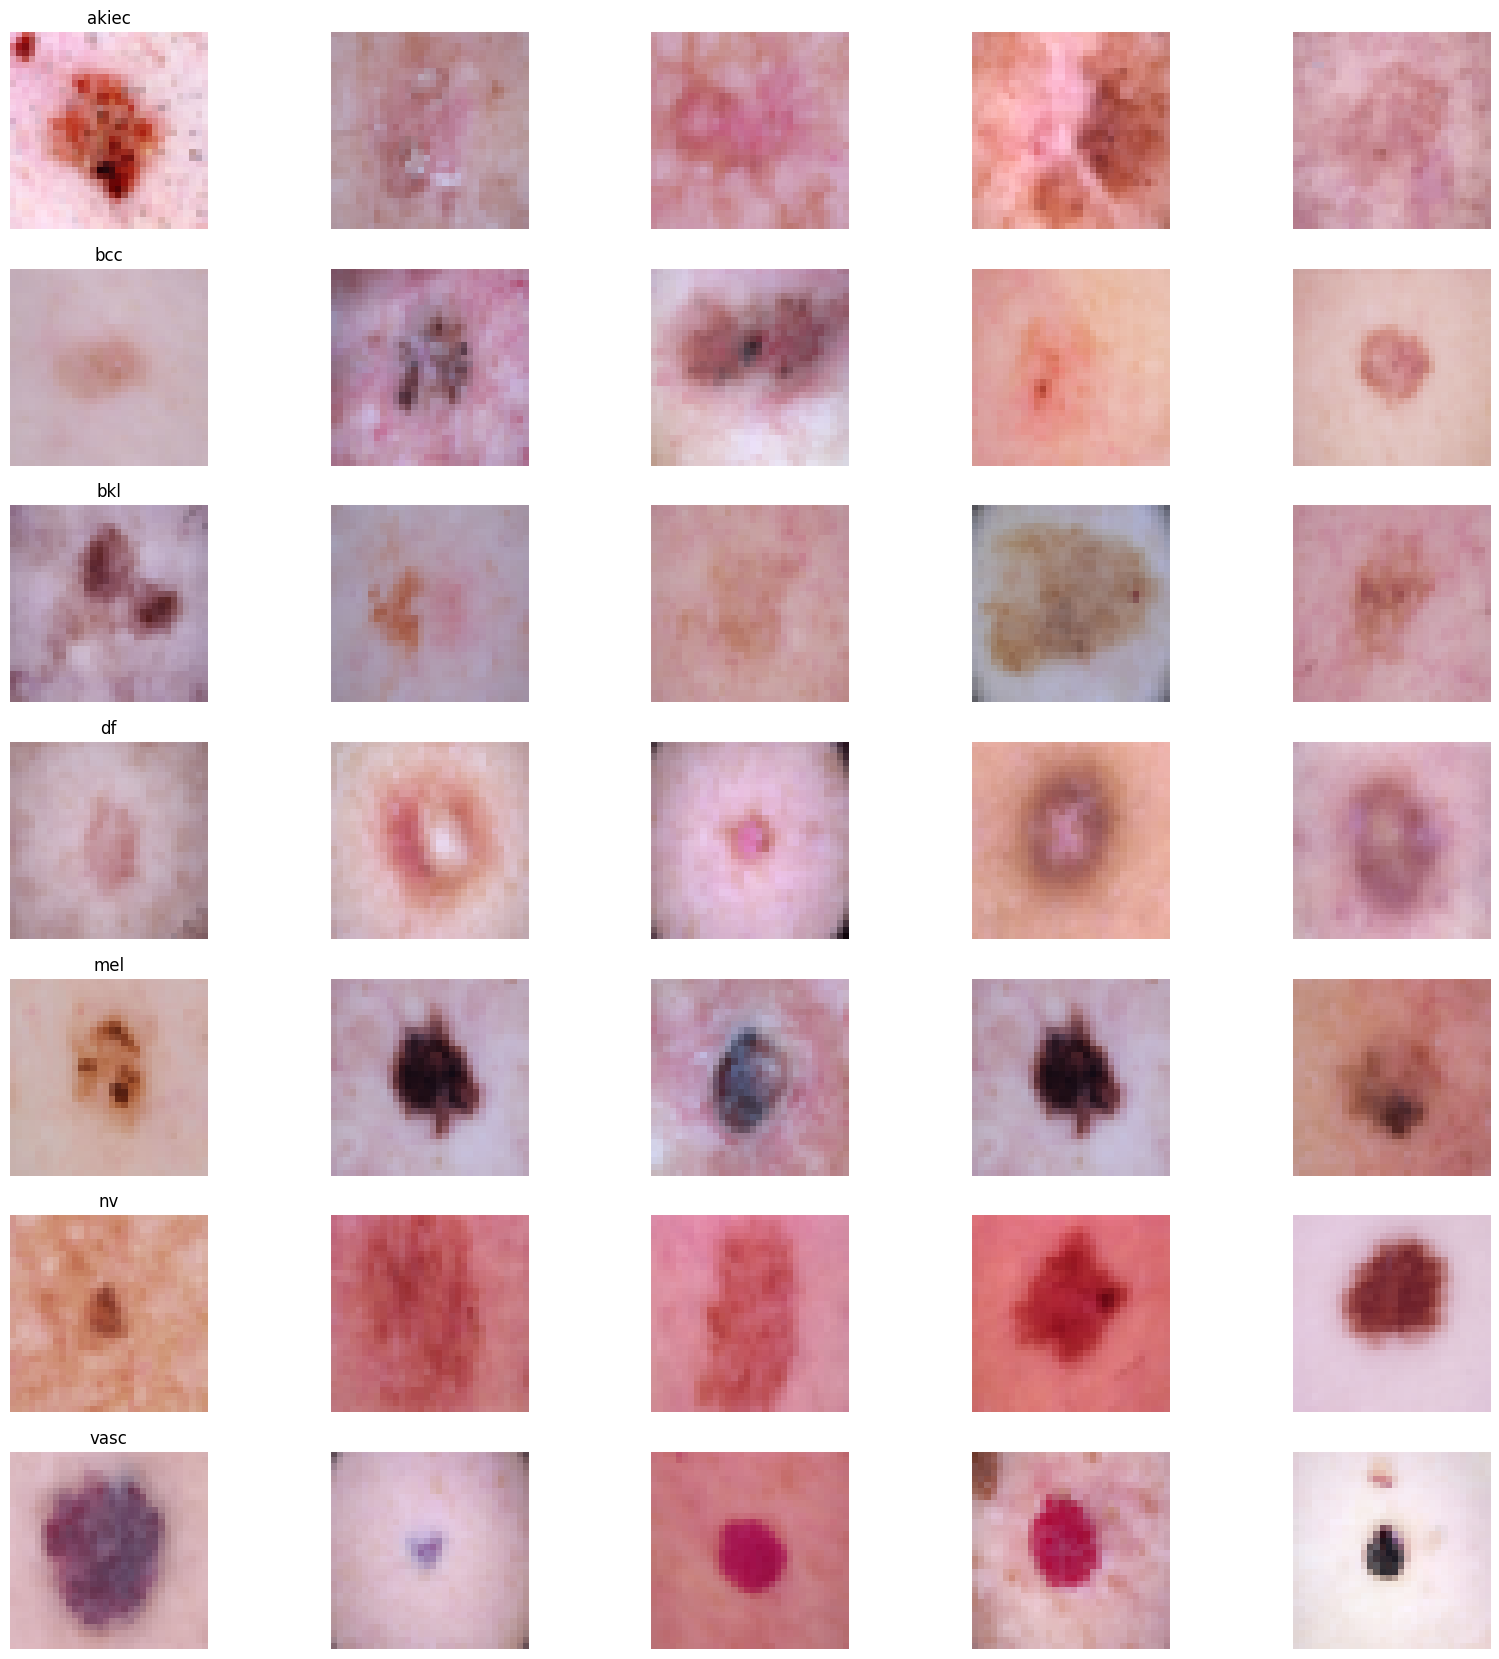

In [23]:
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [24]:
#Converting dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scaling values to 0-1.
Y=skin_df_balanced['label'] #Assigning label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Converting to categorical 

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [26]:
import pickle

with open('trained_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [27]:
batch_size = 16 
epochs = 50
history = loaded_model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50



165/165 - 11s - loss: 1.9330 - acc: 0.1787 - val_loss: 1.8551 - val_acc: 0.2411 - 11s/epoch - 66ms/step
Epoch 2/50
165/165 - 8s - loss: 1.7212 - acc: 0.2956 - val_loss: 1.5481 - val_acc: 0.4103 - 8s/epoch - 46ms/step
Epoch 3/50
165/165 - 8s - loss: 1.5047 - acc: 0.3909 - val_loss: 1.4378 - val_acc: 0.3931 - 8s/epoch - 47ms/step
Epoch 4/50
165/165 - 7s - loss: 1.4447 - acc: 0.4331 - val_loss: 1.5287 - val_acc: 0.4023 - 7s/epoch - 45ms/step
Epoch 5/50
165/165 - 7s - loss: 1.3886 - acc: 0.4430 - val_loss: 1.3979 - val_acc: 0.4400 - 7s/epoch - 44ms/step
Epoch 6/50
165/165 - 7s - loss: 1.3271 - acc: 0.4811 - val_loss: 1.3410 - val_acc: 0.4811 - 7s/epoch - 44ms/step
Epoch 7/50
165/165 - 7s - loss: 1.3130 - acc: 0.4846 - val_loss: 1.3765 - val_acc: 0.4240 - 7s/epoch - 44ms/step
Epoch 8/50
165/165 - 7s - loss: 1.2776 - acc: 0.5021 - val_loss: 1.2857 - val_acc: 0.5029 - 7s/epoch - 44ms/step
Epoch 9/50
165/165 - 7s - loss: 1.2441 - acc: 0.5162 - val_loss: 1.2697 - val_acc: 0.5120 - 7s/epoch - 44

In [28]:
score = loaded_model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 1s 30ms/step - loss: 0.8257 - acc: 0.7063
Test accuracy: 0.7062857151031494
